# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.3.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
# Original dataset includes 10 classes and 60000 examples in training set

# We take only 3 classes and 15,000 examples in the training set

def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    # Shuffle the data without any repetition (no replace)
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    
    x = x[indices]
    y = y[indices]
    
    # Convert the labels into one hot-encoded vector 
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
# Download the original dataset from the server and apply the get_three_classes to it. 

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()

x_train, y_train = get_three_classes (x_train, y_train)

x_test, y_test= get_three_classes (x_test, y_test)

In [4]:
# We have 15,000 and 3,000 examples in the training and the test sets, respectively. 

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


In [7]:
# For instance the y_train represents the following label:

print(y_train)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [8]:
# The following generates an (index) array with 10 unique elements between 0 and 14,999: 

indecies=np.random.choice(range(x_train.shape[0]), 10, replace=False)
print(indecies)

# This returns (samples) the y_train values in the generated random indecies

y_train[indecies]

[ 4930  8595  2208 12559  5937  1367 12997 12179 10104 13280]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

# Task 3: Visualize Examples

In [9]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x,y,p):
    indices=np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range (10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

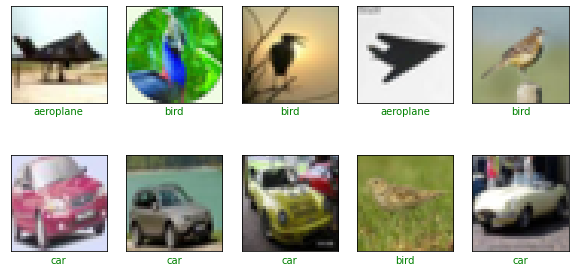

In [10]:
show_random_examples(x_train, y_train, y_train)

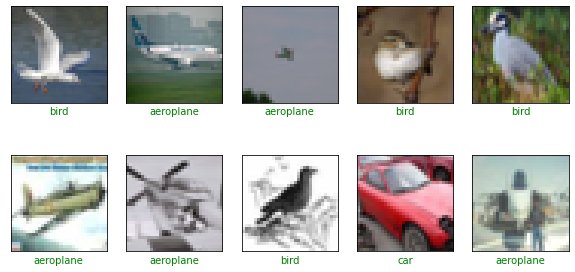

In [11]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    # First, define a block which is going to be used later
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same')) #"same padding" keeps the dimentions unchanged
        model.add(BatchNormalization()) # reduces the covairate shift in the output
        model.add(Conv2D(num_filters, 3, activation='relu')) # "valid" padding changes the dimentions
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5)) # This is a droupout layer
        return model
    
    # Second, define a sequential model from scratch:
    model=tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3))) 
    # Repeat the above block three times: with different fiter sizes
    model= add_conv_block(model, 32)
    model= add_conv_block(model, 64)
    model= add_conv_block(model, 128)
    # Flatten the hidden untis and feed them into a dense layer with three output units correponding to the three classes of the classifier
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    # Add the loss, optimizer and metrics to our model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
    
    
    
    return model

In [23]:
model=create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 15, 64)       

# Task 5: Train the Model

In [28]:
history = model.fit(
    
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=10, batch_size=128,
    
    callbacks=[
        tf.keras.callbacks.EarlyStopping  (monitor='val_accuracy', patience=3), # wait until three epoches if the earlystopping criteria is satisfied 
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5', # save the best model at each epoch in the working directory
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy')]
)

Epoch 1/10
118/118 [==============================] - 28s 236ms/step - loss: 0.8813 - accuracy: 0.6781 - val_loss: 3.5213 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 27s 230ms/step - loss: 0.5535 - accuracy: 0.7763 - val_loss: 2.6093 - val_accuracy: 0.3333
Epoch 3/10
118/118 [==============================] - 28s 240ms/step - loss: 0.4921 - accuracy: 0.8016 - val_loss: 2.5250 - val_accuracy: 0.3340
Epoch 4/10
118/118 [==============================] - 27s 229ms/step - loss: 0.4464 - accuracy: 0.8237 - val_loss: 2.9290 - val_accuracy: 0.4170
Epoch 5/10
118/118 [==============================] - 28s 238ms/step - loss: 0.4147 - accuracy: 0.8365 - val_loss: 0.8262 - val_accuracy: 0.6893
Epoch 6/10
118/118 [==============================] - 28s 239ms/step - loss: 0.3757 - accuracy: 0.8530 - val_loss: 0.4967 - val_accuracy: 0.8297
Epoch 7/10
118/118 [==============================] - 30s 258ms/step - loss: 0.3499 - accuracy: 0.8651 - val_loss: 0.5065 - val_ac

# Task 6: Final Predictions

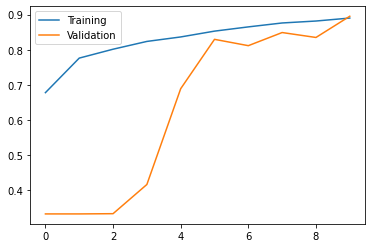

In [29]:
accs=history.history['accuracy']

val_accs= history.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')

plt.legend()
plt.show()


In [30]:
# Load the best model saved in "models" so we can evaluate it with the test set

model=tf.keras.models.load_model('models/model_0.895.h5')

preds=model.predict(x_test/255.)

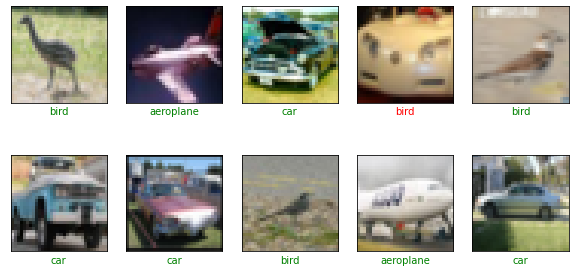

In [32]:
show_random_examples(x_test, y_test, preds)